Using PIF

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import h5py
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nitorch.data import load_nifti
from nitorch.transforms import ToTensor
from pif import PatchIndividualFilters3D

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Parameters

In [5]:
gpu = 7
model_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/full_set/experiment//"
model_path = os.path.join(model_dir,"repeat_0_cv_fold_1_BEST_ITERATION.h5")

### Model definition

In [6]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([10,13,10],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=3,
                                            overlap=1,
                                            reassemble=False,
                                            debug=False)

        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            nn.Linear(1134, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = F.elu(self.pif(x))
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [7]:
# load pre-trained weights
net = SixtyFourNet()
net.load_state_dict(torch.load(model_path))
net = net.cuda(gpu)
net.eval()

SixtyFourNet(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pif): PatchIndividualFilters3D(
    (conv_0): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_1): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_2): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_3): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_4): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_5): Conv3d(64, 3, kernel_size=(3, 3, 

In [8]:
neuron = list(dict(net.named_children())["Conv_1"].parameters())[0][0]

# Generate feature visualization through optimization

### Create starting point

In [9]:
base = torch.rand((1, 96, 114, 96))

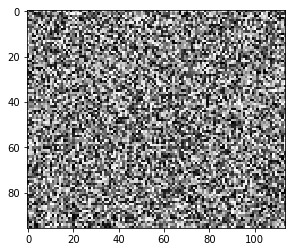

In [10]:
plt.imshow(base[0,:,:,48], cmap='gray')

In [11]:
start, end = 32, 32+5

In [12]:
val_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
X, y = val_h5['X'][start:end], val_h5['y'][start:end]
del val_h5

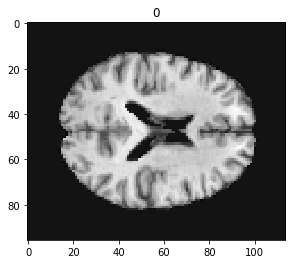

In [13]:
plt.imshow(X[0,:,:,48], cmap='gray')
plt.title(y[0])
plt.show()

In [14]:
for i, img in enumerate(X):
    X[i] = img / np.max(img) # normalize
X = torch.Tensor(X)

In [15]:
n_filters = 5

In [16]:
activation = None
class SaveActivation():
    def __init__(self, n_filters):
        self.activation = []
        self.n_filters = n_filters

    def __call__(self, module, input, output):
        print(output.data.shape)
        print(len(output.data) * self.n_filters)
        for i in range(len(output.data)):
            for j in range(self.n_filters):
                self.activation.append(output.data[i, j])
        
    def get_activation(self):
        return self.activation

In [17]:
saver = SaveActivation(n_filters)
len(saver.get_activation())

0

In [18]:
hook = net.Conv_4.register_forward_hook(saver)

In [19]:
net.forward(torch.unsqueeze(X, 1).cuda(gpu))

torch.Size([5, 64, 10, 13, 10])
25


tensor([[-4.3060],
        [-4.2028],
        [ 3.7886],
        [13.2309],
        [12.8049]], device='cuda:7', grad_fn=<AddmmBackward>)

In [20]:
len(saver.get_activation())

25

In [21]:
saver.n_filters

5

In [22]:
activation_shape = saver.get_activation()[0].shape
n_imgs = len(X)

activations = np.zeros(shape=(n_filters, )+tuple(activation_shape))
print(np.shape(activations))

for i in range(n_imgs):
    print("Next")
    for j in range(n_filters):
        activation = saver.get_activation()[(i*n_filters)+j].cpu().numpy()
        #plt.imshow(activation[:,:,5], cmap='gray')  
        #plt.show()
        activations[j] += activation

(5, 10, 13, 10)
Next
Next
Next
Next
Next


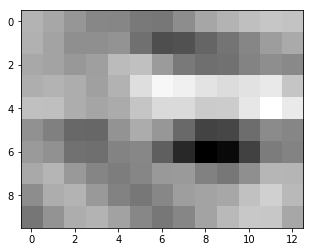

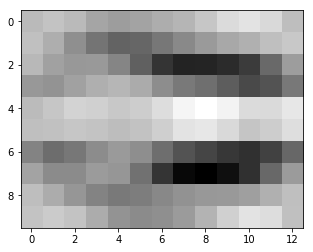

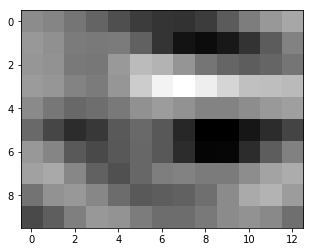

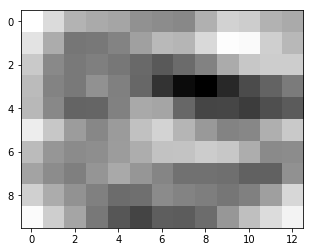

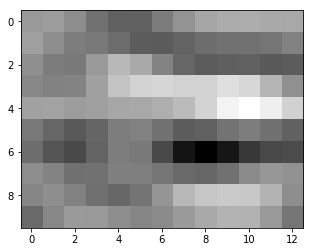

In [23]:
for activation in activations:
    plt.imshow(activation[:,:,5]/n_filters, cmap='gray')
    plt.show()

Backpropagate from feature map

In [24]:
std = torch.Tensor([0.05, 0.05, 0.05, 0.05]).repeat(4,4,1).unsqueeze(0)
gaussian_kernel = torch.normal(mean=1, std=std).unsqueeze(0)

In [25]:
gaussian_kernel.shape

torch.Size([1, 1, 4, 4, 4])

In [26]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        
        self.blur = blur_kernel
        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        #x = self.Conv_4(x) # remove activation to match original feature map
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1)
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [27]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

In [28]:
new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
Conv_4.weight
Conv_4.bias


In [29]:
sub_model.load_state_dict(new_state_dict)

In [30]:
sub_model.cuda(gpu)
sub_model.eval()

SubModel(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
)

In [31]:
X = X.requires_grad_()

In [32]:
sub_model.zero_grad()

In [33]:
res = sub_model.forward(torch.unsqueeze(X, 1).cuda(gpu))

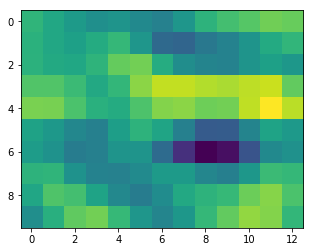

In [34]:
plt.imshow(saver.get_activation()[5].cpu().numpy()[:,:,5])
plt.show()

In [35]:
res_img = res[1].cpu().detach().numpy()

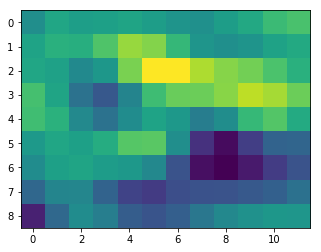

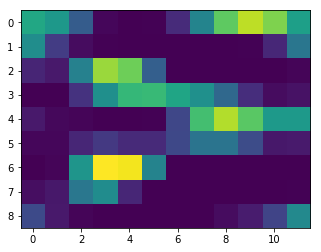

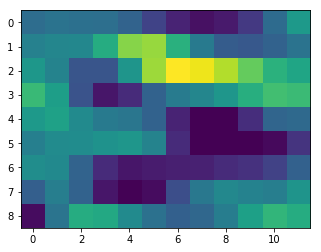

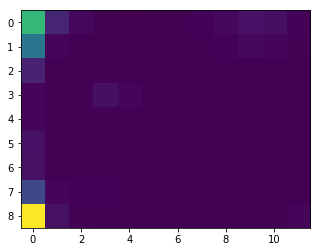

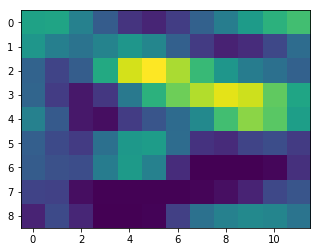

In [36]:
for filter_pos in range(5):
    plt.imshow(res_img[filter_pos][:,:,5])
    plt.show()

In [37]:
res.shape

torch.Size([5, 64, 9, 12, 9])

In [38]:
image_pos = 1
filter_pos = 20

In [39]:
grad = torch.mean(torch.abs(res[image_pos, filter_pos]))

In [40]:
grad.backward()

In [41]:
print(torch.sum(X.grad))

tensor(5.2357)


In [42]:
print(torch.sum(X.grad))

tensor(5.2357)


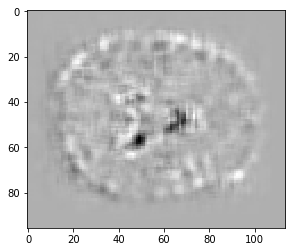

In [43]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

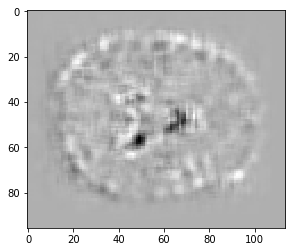

In [44]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

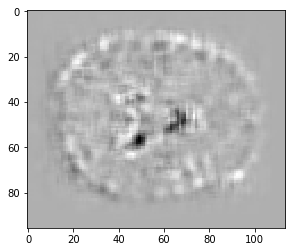

In [45]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

### Optimization loop

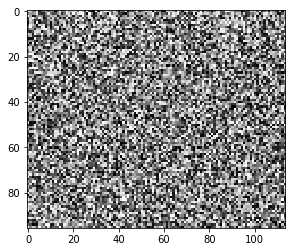

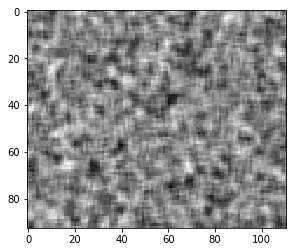

In [46]:
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

smoothed = F.conv3d(base, weight=gaussian_kernel, stride=1)
plt.imshow(smoothed.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

Iteration 0. Loss 0


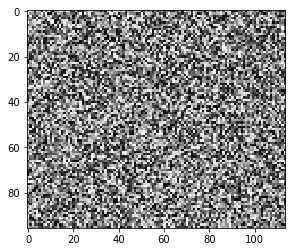

Iteration 200. Loss -978500.75


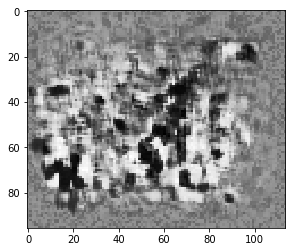

Iteration 400. Loss -2203684.0


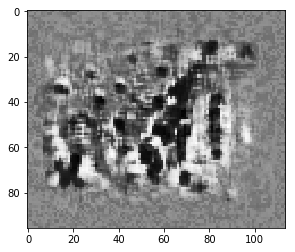

Iteration 600. Loss -3213169.25


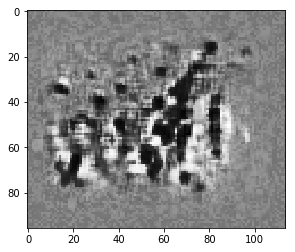

Iteration 800. Loss -4033268.25


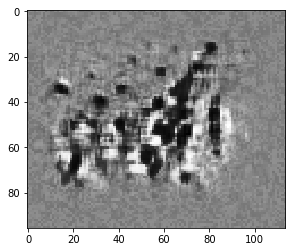

Iteration 1000. Loss -4704133.0


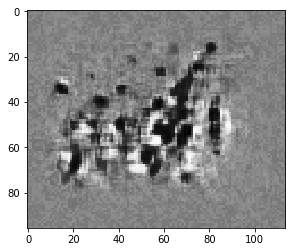

Iteration 1200. Loss -5264863.5


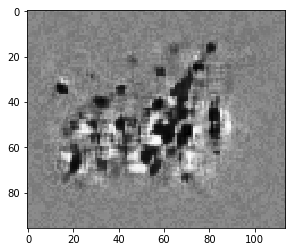

Iteration 1400. Loss -5729829.0


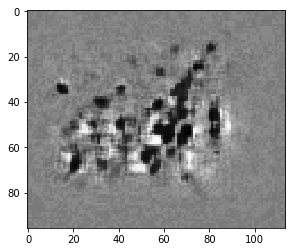

Iteration 1600. Loss -6126713.0


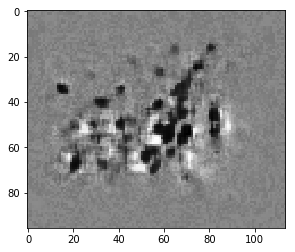

Iteration 1800. Loss -6465401.0


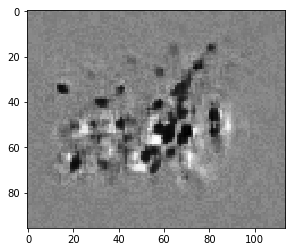

Iteration 2000. Loss -6761685.5


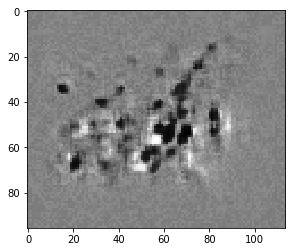

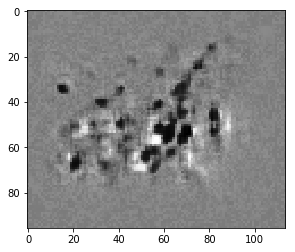

In [47]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [48]:
filter_pos = 10

Iteration 0. Loss 0


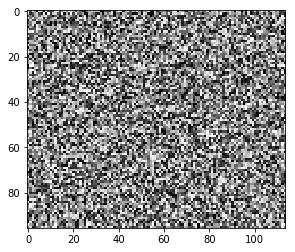

Iteration 200. Loss -804689.5


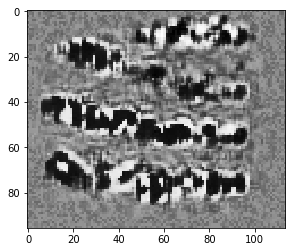

Iteration 400. Loss -1756791.75


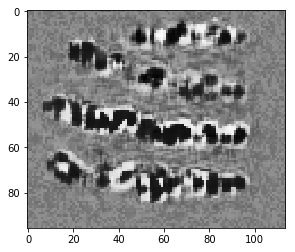

Iteration 600. Loss -2576641.0


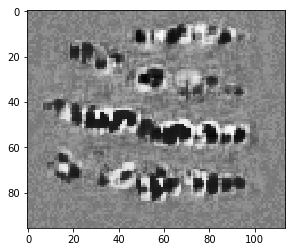

Iteration 800. Loss -3275928.25


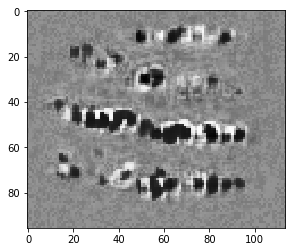

Iteration 1000. Loss -3888252.5


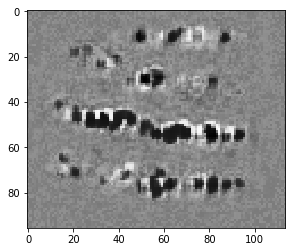

Iteration 1200. Loss -4426663.0


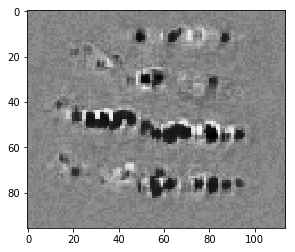

Iteration 1400. Loss -4893106.0


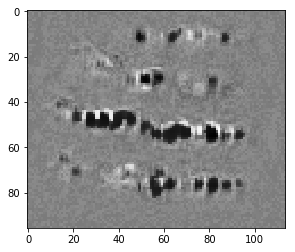

Iteration 1600. Loss -5301917.5


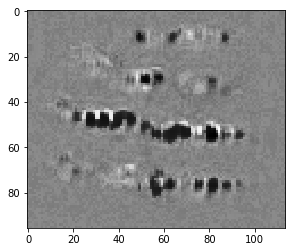

Iteration 1800. Loss -5658758.0


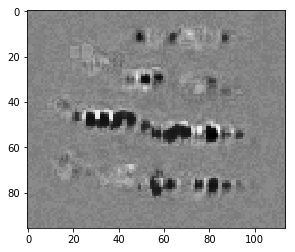

Iteration 2000. Loss -5974841.0


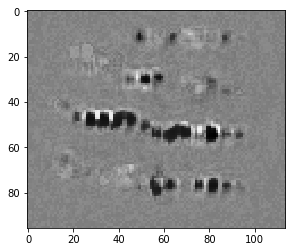

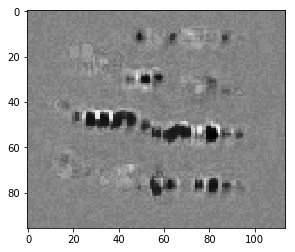

In [49]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [50]:
filter_pos = 43

Iteration 0. Loss 0


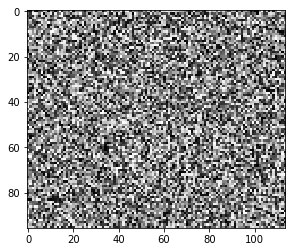

Iteration 200. Loss -2538700.0


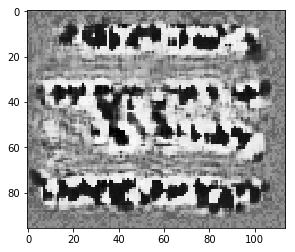

Iteration 400. Loss -5470962.5


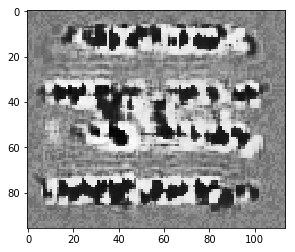

Iteration 600. Loss -8194188.5


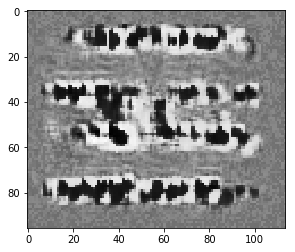

Iteration 800. Loss -10677626.0


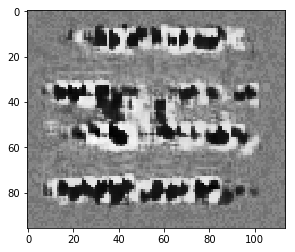

Iteration 1000. Loss -12949421.0


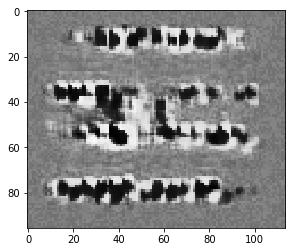

Iteration 1200. Loss -15025388.0


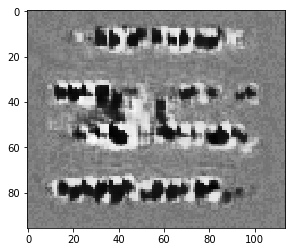

Iteration 1400. Loss -16931322.0


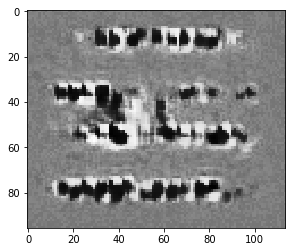

Iteration 1600. Loss -18686790.0


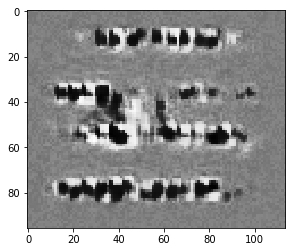

Iteration 1800. Loss -20307368.0


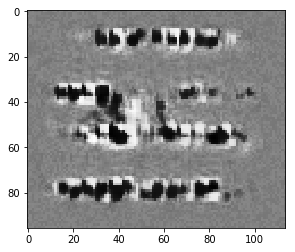

Iteration 2000. Loss -21811936.0


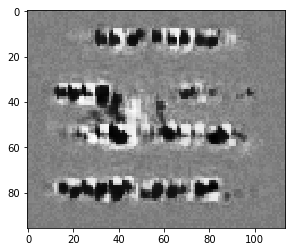

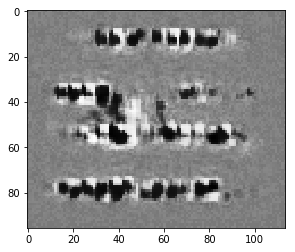

In [51]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [52]:
filter_pos = 43

Iteration 0. Loss 0


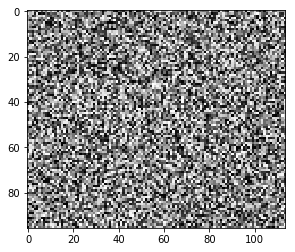

Iteration 200. Loss -2498271.0


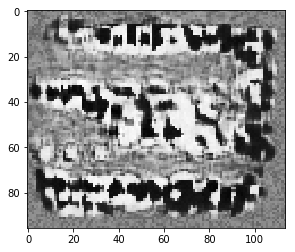

Iteration 400. Loss -5416688.5


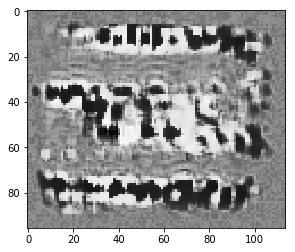

Iteration 600. Loss -8131192.5


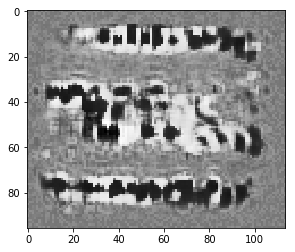

Iteration 800. Loss -10600872.0


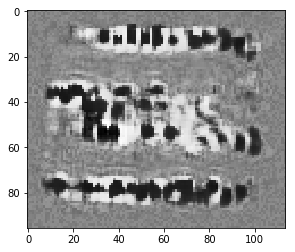

Iteration 1000. Loss -12849877.0


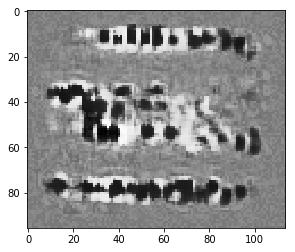

Iteration 1200. Loss -14905822.0


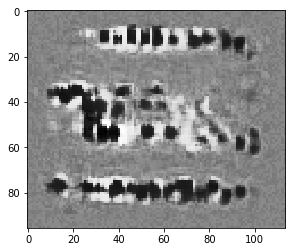

Iteration 1400. Loss -16787608.0


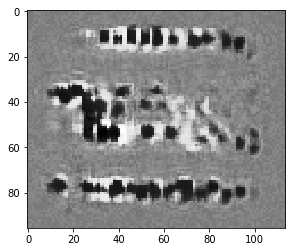

Iteration 1600. Loss -18517242.0


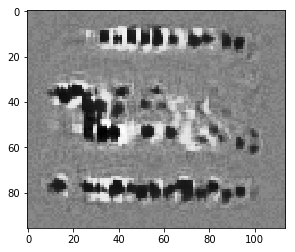

Iteration 1800. Loss -20109960.0


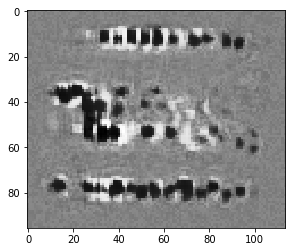

Iteration 2000. Loss -21578880.0


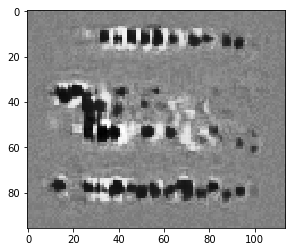

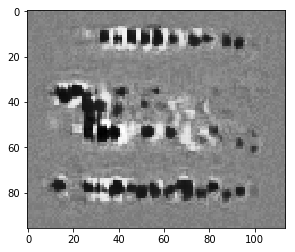

In [53]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [54]:
res = sub_model.forward(base.cuda(gpu))

In [55]:
torch.sum(torch.abs(res[0, filter_pos]))

tensor(21817418., device='cuda:7', grad_fn=<SumBackward0>)

In [56]:
torch.sum(torch.abs(res[0, filter_pos-14]))

tensor(7624633., device='cuda:7', grad_fn=<SumBackward0>)

In [57]:
res = sub_model.forward(torch.unsqueeze(X[[0]], 1).cuda(gpu))

In [58]:
torch.sum(torch.abs(res[0, filter_pos]))

tensor(7535.3916, device='cuda:7', grad_fn=<SumBackward0>)

In [59]:
torch.sum(torch.abs(res[0, filter_pos-14]))

tensor(1135.4155, device='cuda:7', grad_fn=<SumBackward0>)

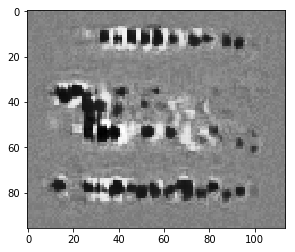

In [60]:
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

## Using PIF Layer as output

In [61]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.blur = blur_kernel
        
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        
        self.pif = PatchIndividualFilters3D([10,13,10],
                                    filter_shape=(3,3,3),
                                    patch_shape=(5,5,5),
                                    num_local_filter_in=64,
                                    num_local_filter_out=3,
                                    overlap=1,
                                    reassemble=False,
                                    debug=False)
        

        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        #x = self.Conv_4(x) # remove activation to match original feature map
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1, padding=1)
        x = self.encode(x, print_size=print_size)
        x = F.elu(self.pif(x))
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [62]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
Conv_4.weight
Conv_4.bias
pif.conv_0.weight
pif.conv_0.bias
pif.conv_1.weight
pif.conv_1.bias
pif.conv_2.weight
pif.conv_2.bias
pif.conv_3.weight
pif.conv_3.bias
pif.conv_4.weight
pif.conv_4.bias
pif.conv_5.weight
pif.conv_5.bias
pif.conv_6.weight
pif.conv_6.bias
pif.conv_7.weight
pif.conv_7.bias
pif.conv_8.weight
pif.conv_8.bias
pif.conv_9.weight
pif.conv_9.bias
pif.conv_10.weight
pif.conv_10.bias
pif.conv_11.weight
pif.conv_11.bias
pif.conv_ov_0.weight
pif.conv_ov_0.bias
pif.conv_ov_1.weight
pif.conv_ov_1.bias


SubModel(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pif): PatchIndividualFilters3D(
    (conv_0): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_1): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_2): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_3): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_4): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_5): Conv3d(64, 3, kernel_size=(3, 3, 3), 

In [63]:
filter_pos = 1

Iteration 0. Loss 0


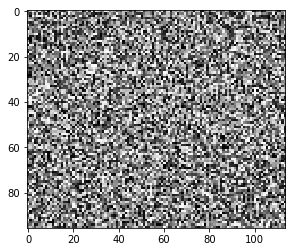

Iteration 200. Loss -893132.6875


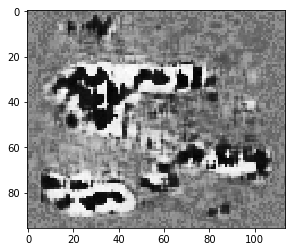

Iteration 400. Loss -1831562.125


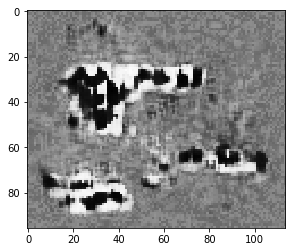

Iteration 600. Loss -2651064.75


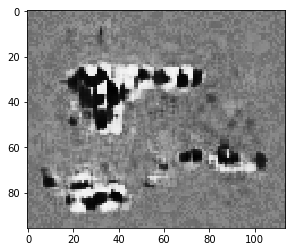

Iteration 800. Loss -3367996.75


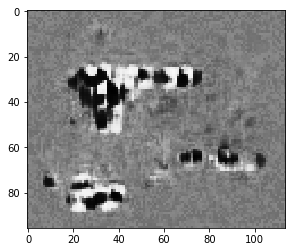

Iteration 1000. Loss -4006352.25


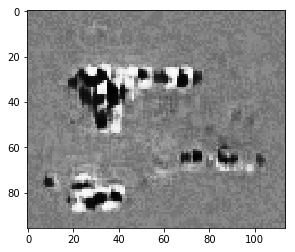

Iteration 1200. Loss -4577155.0


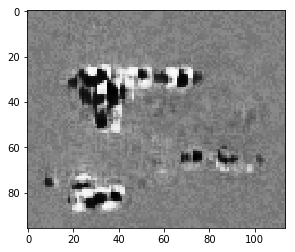

Iteration 1400. Loss -5088253.0


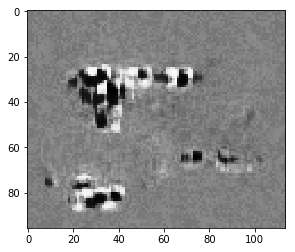

Iteration 1600. Loss -5549327.0


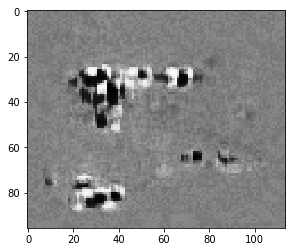

Iteration 1800. Loss -5972231.5


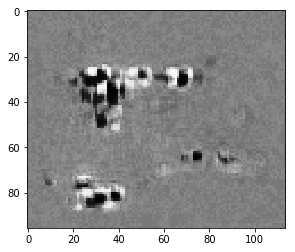

Iteration 2000. Loss -6359451.5


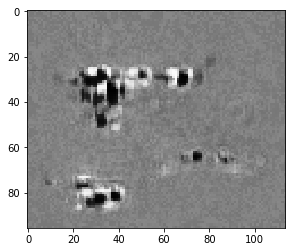

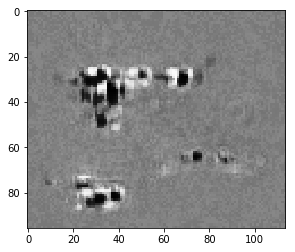

In [64]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [65]:
filter_pos = 2

Iteration 0. Loss 0


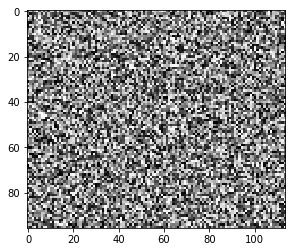

Iteration 200. Loss -1124347.875


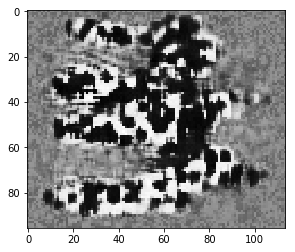

Iteration 400. Loss -2344864.75


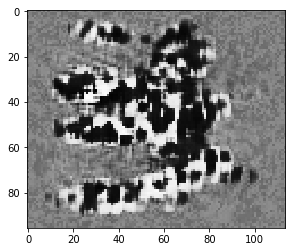

Iteration 600. Loss -3431375.0


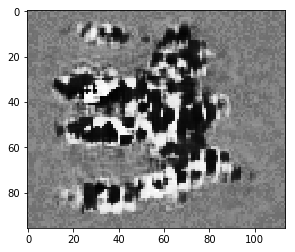

Iteration 800. Loss -4398519.0


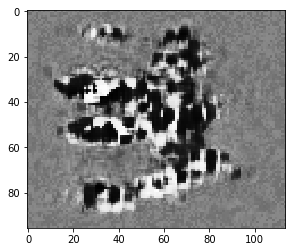

Iteration 1000. Loss -5275762.0


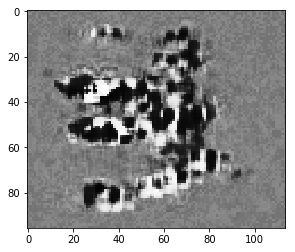

Iteration 1200. Loss -6066726.5


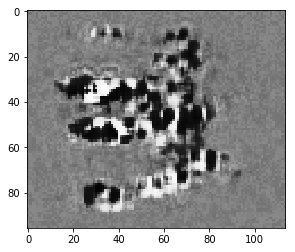

Iteration 1400. Loss -6784932.0


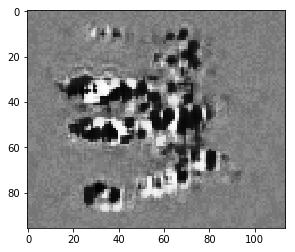

Iteration 1600. Loss -7442082.0


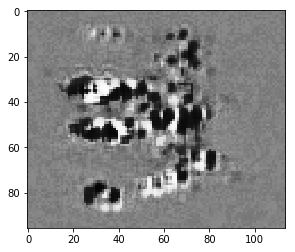

Iteration 1800. Loss -8047144.5


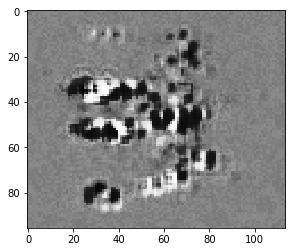

Iteration 2000. Loss -8602483.0


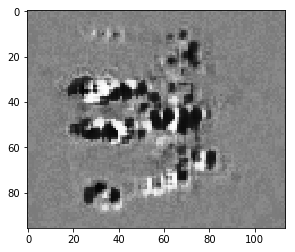

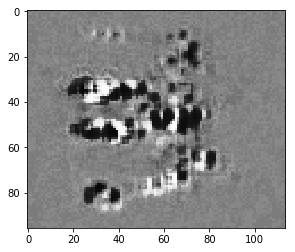

In [66]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

## Early layers

In [67]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.blur = blur_kernel
        
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)

        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1, padding=1)
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [68]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias


SubModel(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
)

In [84]:
def optimize_activations(sub_model, base, optimizer, filter_pos=0, num_iters=2000, show_x=200):
    loss = 0
    l1_loss = nn.L1Loss(reduction='mean')
    
    for i in range(num_iters + 1):
        if i % show_x == 0:
            print("Iteration {}. Loss {}".format(i, loss))
            plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
            plt.show()
        #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
        sub_model.zero_grad()

        res = sub_model.forward(base.cuda(gpu))
        l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
        #print(l1)
        loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
        #print(loss)
        loss.backward()
        optimizer.step()
    print("Final output:")
    plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
    plt.show()

Filter position: 1
Iteration 0. Loss 0


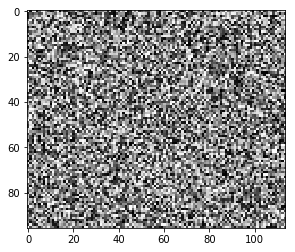

Final output:


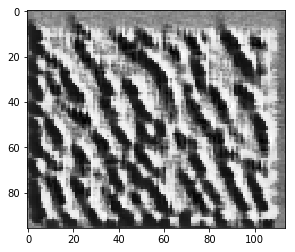

In [70]:
filter_pos = 1
print("Filter position: {}".format(filter_pos)) 
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

optimize_activations(sub_model, base, optimizer, filter_pos=filter_pos, num_iters=num_iters, show_x=num_iters+1)

Filter position: 13
Iteration 0. Loss 0


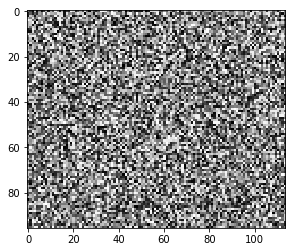

Final output:


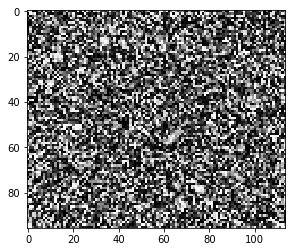

Filter position: 14
Iteration 0. Loss 0


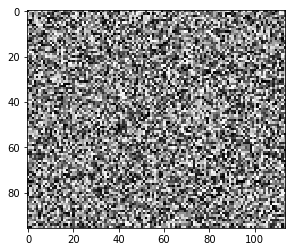

Final output:


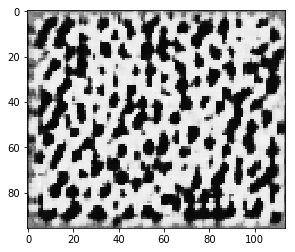

Filter position: 15
Iteration 0. Loss 0


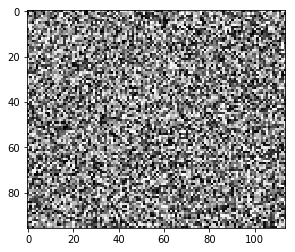

Final output:


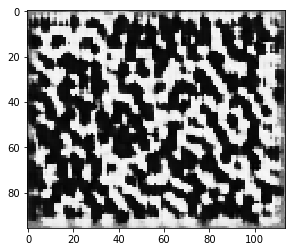

Filter position: 26
Iteration 0. Loss 0


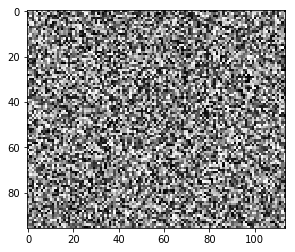

Final output:


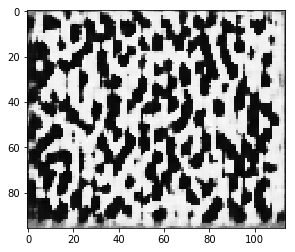

Filter position: 27
Iteration 0. Loss 0


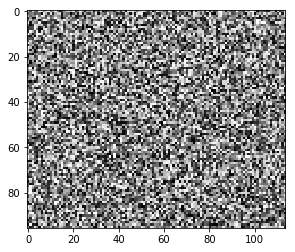

Final output:


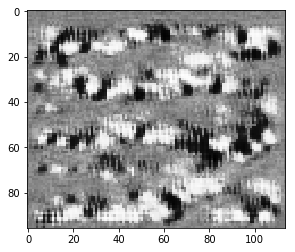

Filter position: 28
Iteration 0. Loss 0


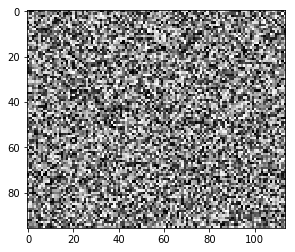

Final output:


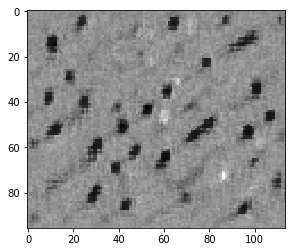

Filter position: 39
Iteration 0. Loss 0


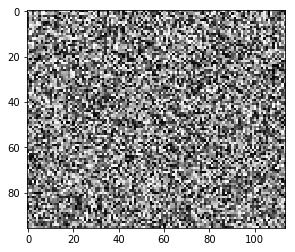

Final output:


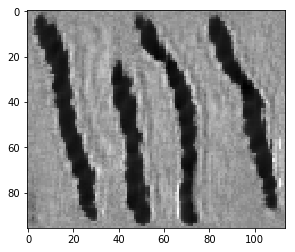

Filter position: 40
Iteration 0. Loss 0


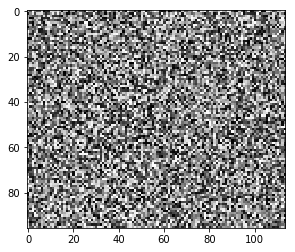

Final output:


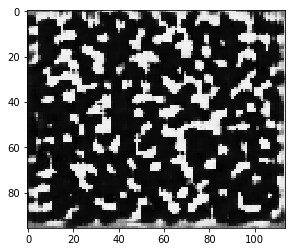

Filter position: 41
Iteration 0. Loss 0


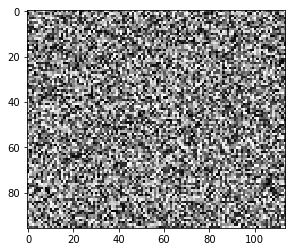

Final output:


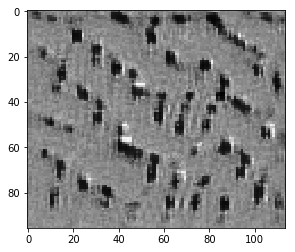

Filter position: 61
Iteration 0. Loss 0


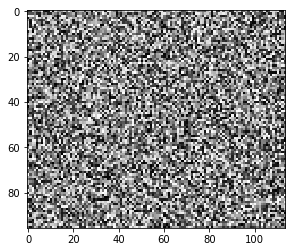

Final output:


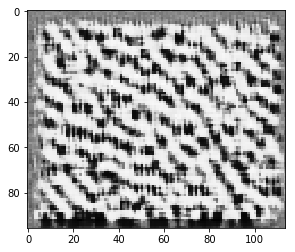

Filter position: 62
Iteration 0. Loss 0


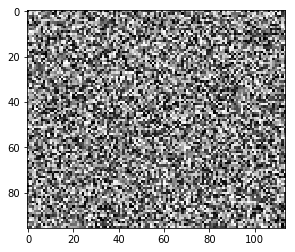

Final output:


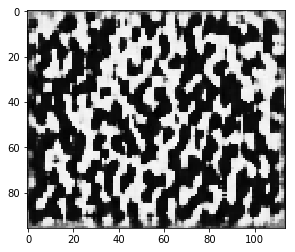

Filter position: 63
Iteration 0. Loss 0


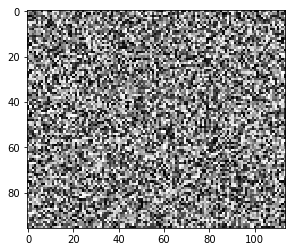

Final output:


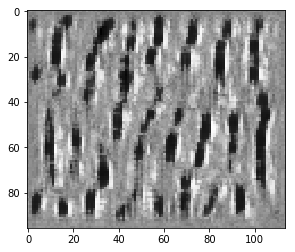

In [71]:
for filter_pos in [13, 14, 15, 26, 27, 28, 39, 40, 41, 61, 62, 63]:
    print("Filter position: {}".format(filter_pos)) 
    num_iters = 2000
    base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
    optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

    optimize_activations(sub_model, base, optimizer, filter_pos=filter_pos, num_iters=num_iters, show_x=num_iters+1)

In [85]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.blur = blur_kernel
        
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)

        
    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1, padding=1)
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [86]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

Conv_1.weight
Conv_1.bias


SubModel(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
)

Filter position: 13
Iteration 0. Loss 0


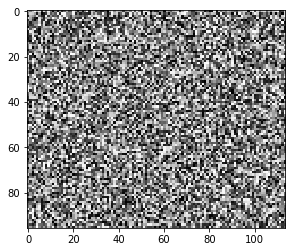

Final output:


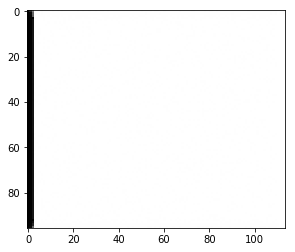

Filter position: 14
Iteration 0. Loss 0


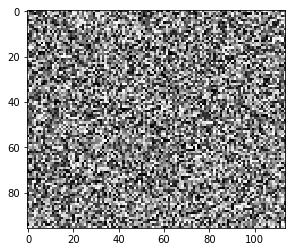

Final output:


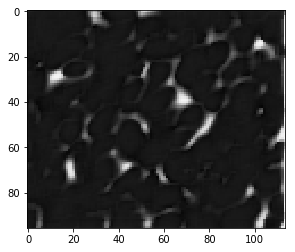

Filter position: 15
Iteration 0. Loss 0


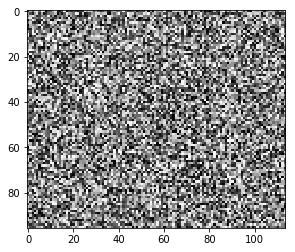

Final output:


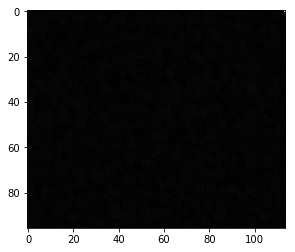

Filter position: 26
Iteration 0. Loss 0


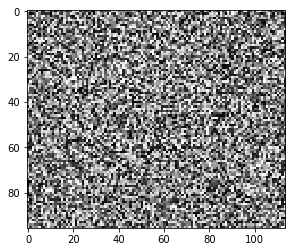

In [ ]:
for filter_pos in [13, 14, 15, 26, 27, 28, 39, 40, 41, 61, 62, 63]:
    print("Filter position: {}".format(filter_pos)) 
    num_iters = 2000
    base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
    optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

    optimize_activations(sub_model, base, optimizer, filter_pos=filter_pos, num_iters=num_iters, show_x=num_iters+1)

## Add transformation robustness

In [82]:
from torchvision import transforms
from nitorch.transforms import Translate, Rotate, Flip

In [ ]:
def optimize_activations(sub_model, base, optimizer, filter_pos=0, num_iters=2000, show_x=200, ps=6,transforms=None):
    loss = 0
    l1_loss = nn.L1Loss(reduction='mean')
    
    for i in range(num_iters + 1):
        base = base.detach()
        base = F.pad(base, pad=(ps,ps,ps,ps,ps,ps))
        if transforms:
            base = transforms(base)
        base = base[:,:,ps:-ps,ps:-ps,ps:-ps]
        if i % show_x == 0:
            print("Iteration {}. Loss {}".format(i, loss))
            plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
            plt.show()
        #base = F.conv3d(base, weight=gaussian_kernel, stride=1)  
        sub_model.zero_grad()
        res = sub_model.forward(base.cuda(gpu))            
        l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
        #print(l1)
        loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
        #print(loss)
        loss.backward()
        optimizer.step()
    print("Final output:")
    plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
    plt.show()

In [ ]:
class TranslateTorch:
    """
    Translate the input along a given axis.

    Arguments:
        axis: axis to rotate. Default is 0
        dist: min and max translation distance in pixels. Randomly 
            translates within that range. Can be scalar, list or tuple. 
            In case of scalar it translates between -abs(dist) and 
            abs(dist). Default is (-3, 3).
    """

    def __init__(self, axis=0, dist=(-3, 3)):
        self.axis = axis

        if isinstance(dist, tuple) or isinstance(dist, list):
            assert len(dist) == 2
            self.min_trans = np.min(dist)
            self.max_trans = np.max(dist)
        else:
            self.min_trans = -int(abs(dist))
            self.max_trans = int(abs(dist))

    def __call__(self, image):
        rand = np.random.randint(self.min_trans, self.max_trans + 1)
        #augmented = torch.zeros(size=image.shape)
        augmented = image.clone()
        #augmented[:] = 0
        if self.axis == 0:
            if rand < 0:
                augmented[:,:,-rand:, :] = image[:,:,:rand, :]
            elif rand > 0:
                augmented[:,:,:-rand, :] = image[:,:,rand:, :]
            else:
                augmented = image
        elif self.axis == 1:
            if rand < 0:
                augmented[:,:,:, -rand:, :] = image[:,:,:, :rand, :]
            elif rand > 0:
                augmented[:,:,:, :-rand, :] = image[:,:,:, rand:, :]
            else:
                augmented = image
        elif self.axis == 2:
            if rand < 0:
                augmented[:,:,:, :, -rand:] = image[:,:,:, :, :rand]
            elif rand > 0:
                augmented[:,:,:, :, :-rand] = image[:,:,:, :, rand:]
            else:
                augmented = image
        image = augmented
        #image[0,0,3,:,:] = 0
        return image

In [ ]:
class FlipTorch:
    """
    Flip the input along a given axis.

    Arguments:
        axis: axis to flip over. Default is 0
        prob: probability to flip the image. Executes always when set to
             1. Default is 0.5
    """

    def __init__(self, axis=0, prob=0.5):
        self.axis = axis
        self.prob = prob

    def __call__(self, image):
        rand = np.random.uniform()
        if rand <= self.prob:
            augmented = torch.flip(image, dims=(self.axis,))
        else:
            augmented = image
        return augmented

In [ ]:
trans_1 = [TranslateTorch(axis=dim, dist=8) for dim in [0, 1, 2]]
trans_2 = [TranslateTorch(axis=dim, dist=3) for dim in [0, 1, 2]]
#rot = [Rotate(axis=dim, deg=5) for dim in [0, 1, 2]]
flip = [FlipTorch(axis=dim, prob=0.5) for dim in [0]] #, 1, 2]] USING ONLY ONE


In [ ]:
#transf = transforms.Compose(trans_1 + flip + trans_2)
transf = transforms.Compose(trans_2)

In [ ]:
filter_pos = 1
print("Filter position: {}".format(filter_pos)) 
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

optimize_activations(sub_model,
                     base,
                     optimizer,
                     filter_pos=filter_pos,
                     num_iters=num_iters,
                     show_x=1,
                     transforms=transf)